In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

<figure id="figure-3">
<div style="background-color: white">

![](figures/dct.svg)</div>
    
<figcaption style="text-align: center">Figure 3: A DCT can be treated as an N channel filter bank where the coefficients of the
filters are the basis functions.</figcaption></figure>

# 7 The Discrete Cosine Transform (DCT)


The DCT is a method of performing energy compaction that is rather different
from the pyramid method.  It operates on non-overlapping blocks of pixels
(typically $8 \times 8$ pixels in size) by a reversible linear transform
process, such that each block of pixels is replaced by a block of the same
number of transform coefficients.  If all the transform coefficients for a
given block are transmitted unaltered to the decoder, then the original block
of pixels can be exactly recovered by the inverse transform process.

In practise the transform coefficients are quantised before transmission, and
if energy compaction has occurred, then fewer bits will be needed to send the
coefficients than the original pixels.  A key advantage of transform-based
methods is that there is no expansion of the number of samples (the
transformed block is the same size as the original block of pixels), whereas
the previous pyramid method expands the data by
$1 + \frac{1}{4} + \frac{1}{16} + \ldots \approx 1.33$ times, which is not very desirable for data
compression.

## 7.1 Definition of the DCT


The one-dimensional form of the DCT is closely related to the Discrete Fourier
Transform (DFT).  The 1-D $N$-point DCT is defined as follows:


$$
y(k) = \sum_{n=0}^{N-1} C_{kn}\ x(n) \quad \text{for} \quad 0 \le k \le N-1 \\
  \text{where }\quad C_{0n} = \sqrt{\frac{1}{N}}  \\
    \text{and } \quad C_{kn} = \sqrt{\frac{2}{N}}\ \cos
\frac{k(n+\frac{1}{2})\pi}{N} \quad \text{for} \quad 1 \le k \le N-1
$$

The equivalent inverse DCT is:
$$
x(n) = \sum_{k=0}^{N-1} C_{kn}\ y(k) \quad \text{for} \quad 0 \le n \le N-1 \\
 \text{where $C_{kn}$ is defined as above.}\\
$$

(This is actually the Type-II DCT, and the inverse is the Type-III DCT - other types have slightly different relative phases})

We see that the forward transform is equivalent to multiplication of the
$N$-point column vector $[x(0) \ldots x(N-1)]'$ by an $N \times N$ matrix,
containing $C_{kn}$ at each location $(k,n)$, to produce the $N$-point column
vector $[y(0) \ldots y(N-1)]'$.  Similarly the inverse transform is equivalent
to multiplication of the $y$ vector by the transpose of the $C$ matrix to give
the $x$ vector.  In python3 + numpy notation these become:

`y = C @ x` and `x = C.T @ y`

Note that C is an orthonormal matrix since its inverse is just its
transpose (its rows are othogonal to each other and have unit energy).

The two-dimensional version of the DCT (as used for image compression) is a
simple extension of the above 1-D DCT.  For an $N \times N$ block of pixels,
the $N$-point 1-D DCT is first applied to each column of the block to give $N$
columns of coefficients.  Then the same 1-D DCT is applied to the rows of
these coefficients to give the 2-D transform coefficients.

In python3 + numpy notation, if the input block of pixels is matrix X, the output
block of 2-D transformed coefficients Y is given by:

`Y = (C @ (C @ X).T).T` or more simply `Y = C @ X @ C.T`

where C is the 1-D transform matrix as above.  Note that in the 2-D
transform, it does not matter whether the rows or the columns are transformed
first (because the transform is linear and separable).


## 7.2 Applying the DCT to images

Conceptually the 2-D DCT is applied to all non-overlapping $N \times N$ blocks
of pixels in an image (we assume that the image dimensions are exact multiples
of $N$).  However it is simplest and most efficient to perform 1-D
$N$-point DCTs on all the columns of the image first, and then repeat the
operation on the transpose of the result to transform the rows.

**First generate an 8-point 1-D Type-II DCT matrix C8**

In [2]:
from cued_sf2_lab.dct import dct_ii

C8 = dct_ii(8)

Take a look at the function `dct_ii` and list `C8` to check
that it agrees with the definitions for $C_{kn}$ given above:

In [3]:
import inspect
import IPython.display
IPython.display.Code(inspect.getsource(dct_ii), language="python")

def dct_ii(N: int) -> np.ndarray:
    """
    Generate the 1D DCT transform matrix of size N.

    Parameters:
    N (int): Size of DCT matrix required

    Returns:
    C (2D np array): 1D DCT transform matrix

    Uses an orthogonal Type-II DCT.
    Y = C * X tranforms N-vector X into Y.
    """
    C = np.ones((N, N)) / np.sqrt(N)
    theta = (np.arange(N) + 0.5) * (np.pi/N)
    g = np.sqrt(2/N)
    for i in range(1, N):
        C[i, :] = g * np.cos(theta*i)

    return C

**Plot the rows of `C8` using `plot(C8.T)`.**

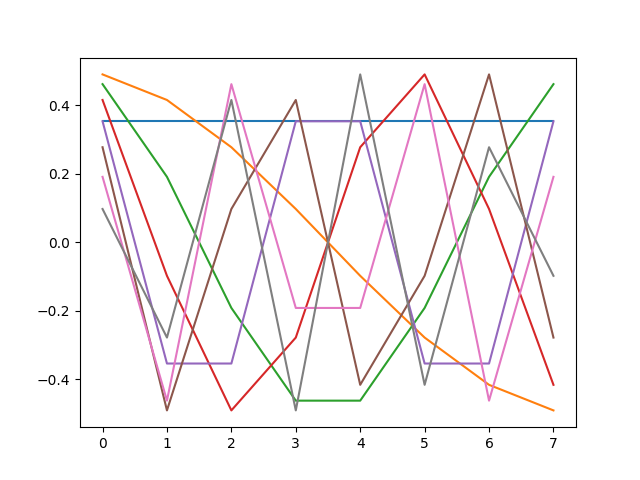

In [4]:
fig, ax = plt.subplots()
ax.plot(C8.T);


When we calculate the 1-D transform of an 8-point block of data, each
transform coefficient represents the component of the data that is
correlated with the corresponding row of `C8`.  Hence the
first coefficient represents the dc component, the second one
represents the approximate average slope, and so on. The later
coefficients represent progressively higher frequency components
in the data.

The function `colxfm(X, C8)` will perform a 1-D transform on
the columns of image `X` using `C8`. We can
therefore perform a 2-D transform on `X` by using `colxfm` twice, once with transpose operators, as follows:

In [5]:
from cued_sf2_lab.familiarisation import load_mat_img
from cued_sf2_lab.dct import colxfm

X_pre_zero_mean, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X_pre_zero_mean - 128.0

Y = colxfm(colxfm(X, C8).T, C8).T

In [6]:
import inspect
import IPython.display
IPython.display.Code(inspect.getsource(colxfm), language="python")

def colxfm(X: np.ndarray, C: np.ndarray) -> np.ndarray:
    """
    Transforms the columns of X using the tranformation in C.

    Parameters:
        X: Image whose columns are to be transformed
        C: N-size 1D DCT coefficients obtained using dct_ii(N)
    Returns:
        Y: Image with transformed columns

    PS: The height of X must be a multiple of the size of C (N).
    """
    N = len(C)
    m, n = X.shape

    # catch mismatch in size of X
    if m % N != 0:
        raise ValueError('colxfm error: height of X not multiple of size of C')

    Y = np.zeros((m, n))
    # transform columns of each horizontal stripe of pixels, N*n
    for i in range(0, m, N):
        Y[i:i+N, :] = C @ X[i:i+N, :]

    return Y

In `Y`, each $8 \times 8$ block of pixels has been replaced by an
equivalent block of transform coefficients.  The coefficient in the top left
corner of each block represents the dc value of the block of pixels;
coefficients along the top row represent increasing horizontal frequency
components, and along the left column represent increasing vertical frequency
components.  Other coefficients represent various combinations of horizontal
and vertical frequencies, in proportion to their horizontal and vertical
distances from the top left corner.

If we try to display `Y` directly as an image, it is rather
confusing because the different frequency components of each block
are all present adjacent to each other.  

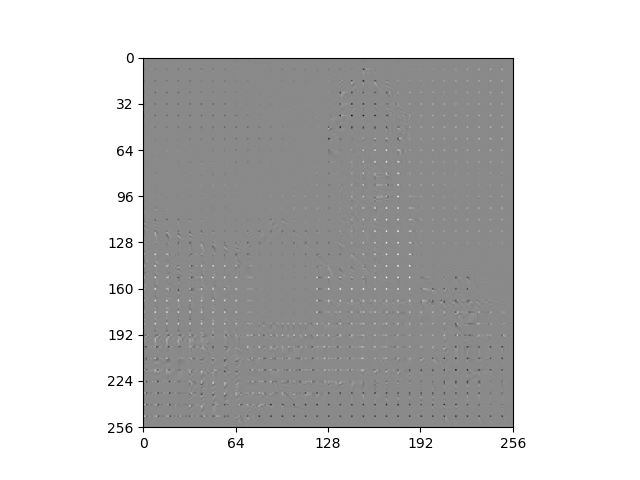

In [7]:
from cued_sf2_lab.familiarisation import plot_image

fig, ax = plt.subplots()
plot_image(Y, ax=ax);

A much more meaningful
image is created if we group all the coefficients of a given type
together into a small sub-image, and display the result as an $8
\times 8$ block of sub-images, one for each coefficient type.  The
function `regroup(Y, N)` achieves this regrouping, where $N$ is
the size of the original transform blocks. You need to ensure that X has zero mean (by subtracting 128) before you start transforming it, otherwise the dc coefficient will be purely positive, whereas the
others are symmetrically distributed about zero. Also, an $N
\times N$ 2-D DCT introduces a gain factor of $N$ in order to
preserve constant total energy between the pixel and transform
domains: we need to divide by $N$ *when displaying* to get back to the expected range.

Hence we can display `Y` meaningfully using:

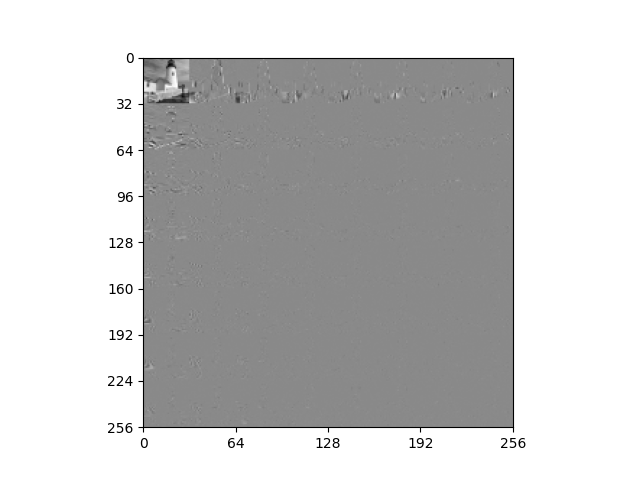

In [8]:
from cued_sf2_lab.dct import regroup

N = 8
fig, ax = plt.subplots()
plot_image(regroup(Y, N)/N, ax=ax);

In this image, you should see a small replica of the original in the top left
corner (the dc coefficients), and other sub-images showing various edges from
the original, representing progressively higher frequencies as you move
towards the lower right corner.

<div class="alert alert-block alert-danger">

What do you observe about the energies of the sub-images as frequencies
increase?</div>

Text(0.5, 1.0, 'Log energy for each frequency in DCT regrouped image')

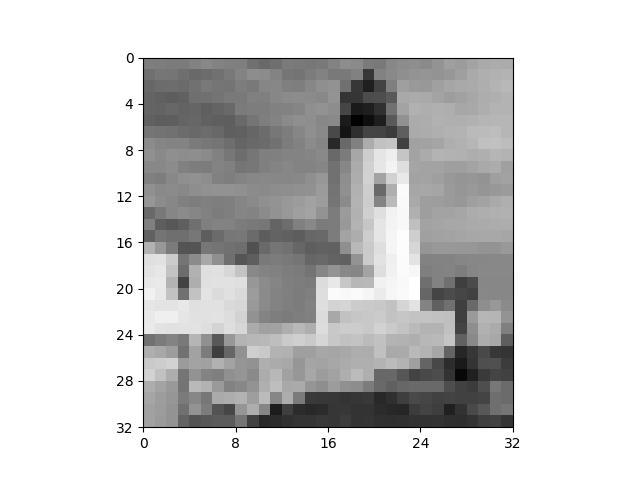

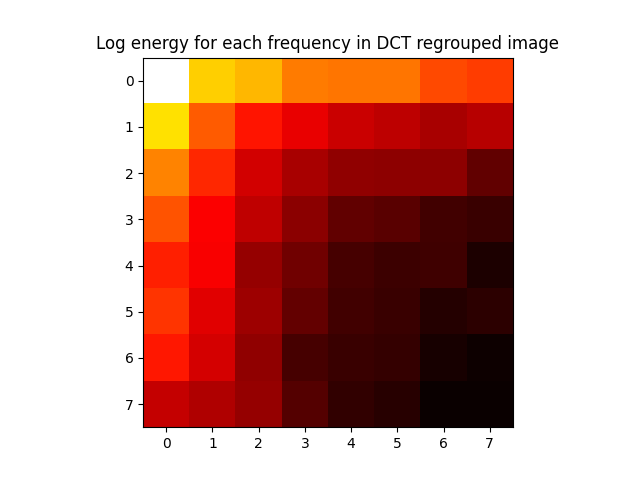

In [33]:
# Your code here
"""
TO BE REVISED
The energies of the sub-images decrease as the frequencies increase.
I suspect this is because low-energy components in real-world images dominate (which was the principal
of the Laplacian pyramid we did last week.)
"""

# Set up regrouped_image
N = 8
regrouped_image = regroup(Y, N)/N
#fig, ax = plt.subplots()
#plot_image(regrouped_image, ax=ax);

#(Some chatgpt help here)

# Reshape the image into a 4D array with shape (8, 32, 8, 32)
reshaped_image = regrouped_image.reshape(8, 32, 8, 32)
#fig, ax = plt.subplots()
#plot_image(reshaped_image[0,:,0,:], ax=ax);

# Permute the axes to obtain the desired shape (8, 8, 32, 32)
reshaped_image = reshaped_image.transpose(0, 2, 1, 3)
fig, ax = plt.subplots()
plot_image(reshaped_image[0,0], ax=ax);


# Iterate over the reshaped_image and print each 8x8 block
energies = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        block = reshaped_image[i, j]   
        energies[i,j] = np.sum(block**2.0)

log_energies = np.log(energies)

fig, ax = plt.subplots()
ax.imshow(log_energies, cmap='hot')
plt.title("Log energy for each frequency in DCT regrouped image")


Now check that you can recover the original image from Y
by carrying out the inverse transform using:

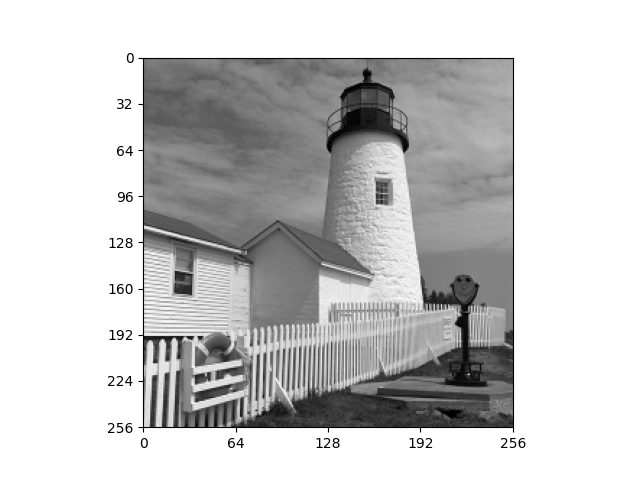

In [34]:
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

fig, ax = plt.subplots()
plot_image(Z, ax=ax);

**Measure the maximum absolute error between X and Z
to confirm this.**

In [11]:
# Your code here

max_abs_error = np.max(np.abs(X-Z))
print(f'Maximum Absolute Error = {max_abs_error}')
print(f'c.f. max pixel intensity = {np.max(X)}')

Maximum Absolute Error = 6.110667527536862e-13
c.f. max pixel intensity = 120.0


The DCT analyses each $8 \times 8$ block of image pixels into a linear
combination of sixty-four $8 \times 8$ basis functions.  The following will generate
an image comprising these basis functions (the `np.nan`s separate the sub-images as matplotlib draws them as transparent, and the `reshape` function converts from a matrix to a row vector):

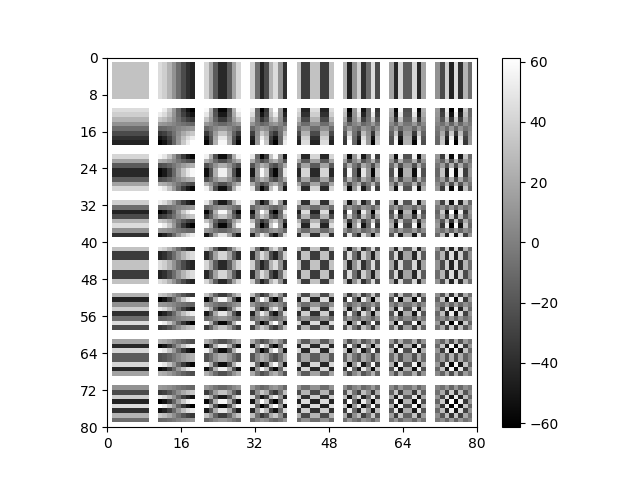

In [12]:
import numpy as np
# Stack some NaNs
bases = np.concatenate([np.full((8, 1), np.nan), C8, np.full((8, 1), np.nan)], axis=1)

# Reshape
bases_flat = np.reshape(bases, (-1, 1))

fig, ax = plt.subplots()
im = plot_image(255*bases_flat@bases_flat.T, ax=ax)
fig.colorbar(im);

<div class="alert alert-block alert-danger">

Explain how this image relates to the DCT coefficients.</div>

In [13]:
"""

This image describes the filters that the image goes through when it runs through the DCT algorithm.
This is best seen compared with the 'meaningful image' that we generated from Y, where we can see the
filters at work.

Top left: DC level, mostly transient. [usually high energy?]
Bottom left: High frequency components.

"""

"\n\nThis image describes the filters that the image goes through when it runs through the DCT algorithm.\nThis is best seen compared with the 'meaningful image' that we generated from Y, where we can see the\nfilters at work.\n\nTop left: DC level, mostly transient. [usually high energy?]\nBottom left: High frequency components.\n\n"

## 7.3 Quantisation and Coding Efficiency

We are now going to look at the effects of quantising the DCT coefficients
fairly coarsely and determine the entropies of the coefficient sub-images.
At this stage we shall quantise all sub-images with the same step-size,
since they all are the same size and have unit energy gain from the
quantiser to the output image (due to the orthonormal transform matrices).

First quantise the transformed image Y using a step size
of 17 to give Yq.  Then regroup Yq to form
sub-images of each coefficient type as before, to give Yr. These sub-images have different probability distributions and we can take advantage of this later in coding them efficiently. Hence we get a better estimate of the number of bits required to code Yq by looking at the entropies of each of the re-grouped sub-images separately.

**Write a function `dctbpp(Yr, N)` to calculate the total number of bits from a re-grouped image Yr, by using `bpp(Ys)` on each sub-image Ys of Yr, then multiplying each result by the number of pixels in the sub-image, and summing to give the total number of bits.**

In [68]:
"""Jensen's functions for this notebook"""

def dct(X):
    Y = colxfm(colxfm(X, C8).T, C8).T
    return Y


def dct_reshape(Yr, N = 8):
    # Reshape the image into a 4D array with shape (8, 32, 8, 32)
    Yrr = Yr.reshape(8, 32, 8, 32) # TODO Variable N
    # Permute the axes to obtain the desired shape (8, 8, 32, 32)
    Yrr = Yrr.transpose(0, 2, 1, 3)
    return Yrr

def idct(Y):
    Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)
    return Z




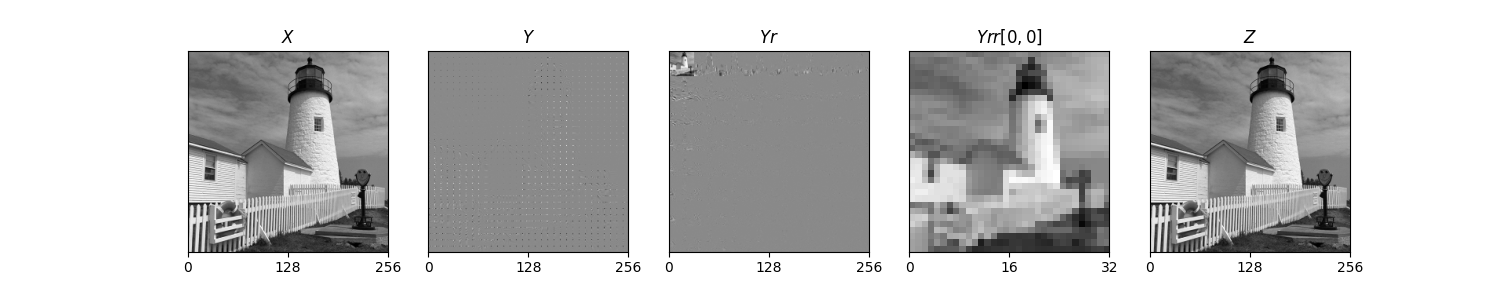

In [70]:
Y = dct(X)
N = 8
Yr = regroup(Y, N)/N
Yrr = dct_reshape(Yr)
Z = idct(Y)

# Plot multiple images
titles = ["X", "Y", "Yr", "Yrr[0,0]", "Z"]
imgs = [X, Y, Yr, Yrr[0,0], Z]
fig, axs = plt.subplots(1, len(imgs), figsize=(15,3))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

In [74]:
from cued_sf2_lab.laplacian_pyramid import bpp

def dctbpp(Yr, N):
    # Your code here
    Yrr = dct_reshape(Yr, N)
    sum = 0
    for row in Yrr:
        for Ys in row:
            sum += bpp(Ys) * Ys.size

    return sum
    

<div class="alert alert-block alert-danger">

Visualise Yr and comment on the distributions in each of the sub-images. Use the function `dctbpp(Yr, N)` that you have written to calculate the total number of bits, and compare it with just using `bpp(Yr)`, explaining your results.

</div>

Yr dctbpp bits = 164492.36674130222
Yr raw bits = 177786.6827283808
X bits = 493398.1567807871


'\n\nEntropy for whole Yr would be higher because it includes information from\nall frequency components combined, so the distribution of pixel intensities\nwill be more even for the entropy for the whole of Yr than the sum of individual\nsub-images. \n\n\nThe distributions in each of the sub-images:\n(Not sure what to comment honestly)\nMain image seen clearly with lower resolution in first sub-image,\nhorizontal lines seen in left column, vertical in top row.\nThe rest are a mixture of frequencies vertically and horizontally, \nwith increasing frequency towards bottom right corner.\n\n'

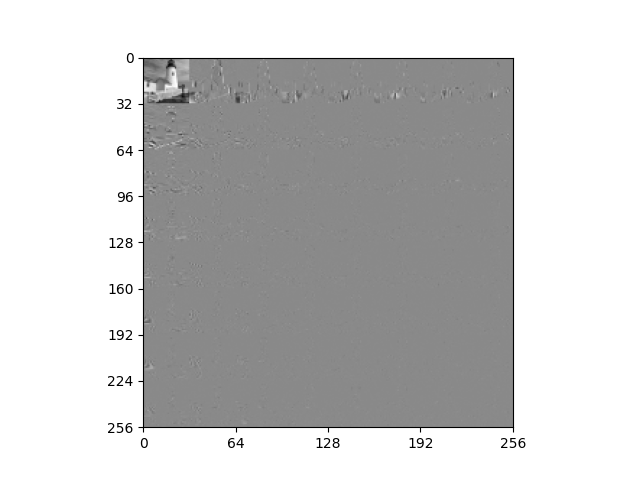

In [81]:
# Your code here

N = 8
Yr = regroup(Y, N)/N

#Visualise Yr
fig, ax = plt.subplots()
plot_image(Yr, ax=ax)

dctbits = dctbpp(Yr,N)
print(f"Yr dctbpp bits = {dctbits}")
print(f"Yr raw bits = {bpp(Yr)*Yr.size}")
print(f"X bits = {bpp(X)*X.size}")


"""

Entropy for whole Yr would be higher because it includes information from
all frequency components combined, so the distribution of pixel intensities
will be more even for the entropy for the whole of Yr than the sum of individual
sub-images. 


The distributions in each of the sub-images:
(Not sure what to comment honestly)
Main image seen clearly with lower resolution in first sub-image,
horizontal lines seen in left column, vertical in top row.
The rest are a mixture of frequencies vertically and horizontally, 
with increasing frequency towards bottom right corner.

"""

<div class="alert alert-block alert-danger">

Now reconstruct the output image `Z` from `Yq` and measure the rms
error (standard deviation) between `X` and `Z`.  Compare this with the
error produced by quantising `X` with a step-size of 17 to give `Xq`.

</div>

RMS_X: 4.861168497356846, RMS_Z: 3.756757368843634


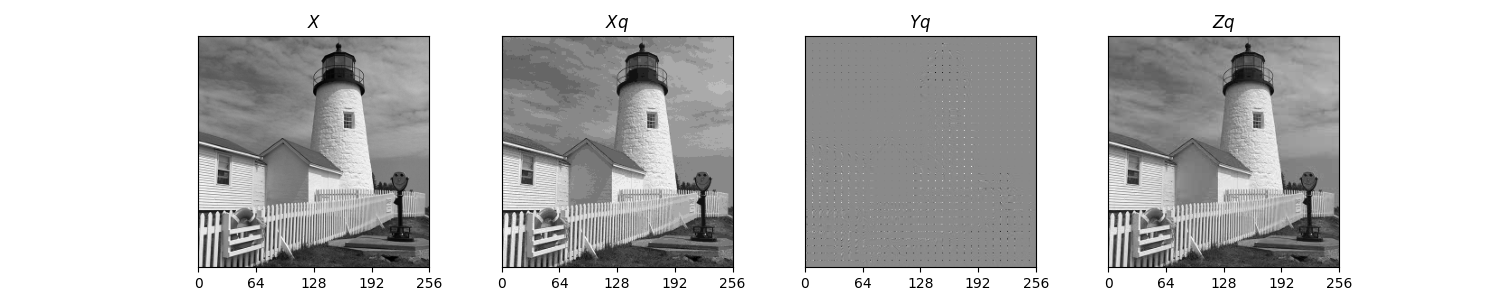

In [85]:
# Your code here
from cued_sf2_lab.laplacian_pyramid import quantise

step = 17
Yq = quantise(Y,step)
Xq = quantise(X,step)
RMS_X = np.std(X-Xq)
Zq = idct(Yq)
RMS_Z = np.std(X-Zq)
print(f"RMS_X: {RMS_X}, RMS_Z: {RMS_Z}")

# Plot multiple images
titles = ["X", "Xq", "Yq", "Zq"]
imgs = [X, Xq, Yq, Zq]
fig, axs = plt.subplots(1, len(imgs), figsize=(15,3))
for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

***As with the Laplacian Pyramid, we really need to contrast compression ratios and visual results on compressed images with the same rms error. Re-use your step optimisation code to calculate the (non-integer) step size required in this case for the same rms error as quantising X with a step-size of 17.***

In [87]:
# Your code here

def objective(step):
    Xq = quantise(X,17)
    var_x = np.std(X-Xq)

    Y = dct(X)
    Yq = quantise(Y, step)
    Zq = idct(Yq)
    var_z = np.std(X-Zq)

    return(abs(var_z - var_x))

def rms(step):
    Y = dct(X)
    Yq = quantise(Y, step)
    Zq = idct(Yq)
    var_z = np.std(X-Zq)
    return var_z


from scipy.optimize import minimize
result = minimize(objective, 10, method='Nelder-Mead')
#print(result)

step_final = result.x[0]
print(f"Final step = {step_final}")
print(f"Final Zq RMS: {rms(step_final)}")
print(f"Difference from Xq RMS: {objective(step_final)}")



Final step = 23.691162109375
Final Zq RMS: 4.861171981753634
Difference from Xq RMS: 3.4843967879893967e-06


<div class="alert alert-block alert-danger">

Calculate the compression ratio for this scheme compared to direct quantisation. Use `dctbpp` to calculate the number of bits needed. Contrast the visual appearance of the DCT-compressed image, the directly quantised image, and the original image.

</div>

In [94]:
# Your code here

N = 8

Xq = quantise(X,17)
Y = dct(X)
Yq = quantise(Y, step_final)
Yqr = regroup(Yq, N)/N
Zq = idct(Yq)


e_x = bpp(X) * X.size
e_xq = bpp(Xq) * Xq.size
e_y = dctbpp(Y, N)
e_yq = dctbpp(Yq, N)
compression_ratio = e_xq / e_yq

print(f"Unquantised X bits needed = {e_x}")
print(f"Quantised Xq bits needed = {e_xq}")
print(f"Unquantised Y bits needed = {e_y}")
print(f"Quantised Yq bits needed = {e_yq}")
print(f"\nCompression ratio = {compression_ratio}")

# Equal RMS verify:
print("\nEqual RMS Verify:")
print(f"Xq RMS = {np.std(X-Xq)}")
print(f"Yq RMS = {np.std(X-Zq)}")



Unquantised X bits needed = 493398.1567807871
Quantised Xq bits needed = 228119.03651868744
Unquantised Y bits needed = 323881.76252121606
Quantised Yq bits needed = 79802.16195052091

Compression ratio = 2.8585570984922217

Equal RMS Verify:
Xq RMS = 4.861168497356846
Yq RMS = 4.861171981753634



## 7.4 Alternative transform sizes

So far, we have concentrated on $8 \times 8$ DCTs using C8
as the 1-D transform matrix.  **Now generate 4-point and 16-point
transform matrices, C4 and C16 using `dct_ii`.**


In [ ]:
# Your code here

<div class="alert alert-block alert-danger">

Repeat the main measurements from the previous section, so as to obtain
estimates of the number of bits and compression ratios for $4 \times 4$ and $16 \times 16$ DCTs when the
rms errors are equivalent to those in your previous tests.  Also assess the
relative subjective quality of the reconstructed images.</div>

In [ ]:
# Your code here


This analysis is in fact slightly biased because with larger transform sizes the function `dctbpp(Yr, N)` will use a greater number of smaller sub-images on which to calculate probability distributions. It may be better to use the same N in this function even when the actual transform changes; however whether this is more predictive of actual coding performance depends on what scanning method is used in the coding scheme.

<div class="alert alert-block alert-danger">

What happens in the limit if you use `dctbpp(Yr, 256)` (i.e. the entropy is calculated independently for each pixel)? Why is this the case, and why isn't this a realistic result?</div>

In [ ]:
# Your code here

<div class="alert alert-block alert-danger">

Can you draw any conclusions about the best choice of transform size for the
Lighthouse image?  Try to postulate what features in other images might make your
conclusions different, and suggest why.</div>

In [ ]:
# Your code here